# Batchnorm и Dropout

In [36]:
from tensorflow.keras.datasets import cifar10

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from skimage import io, transform

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

## Предобработка данных

In [147]:
classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

def get_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = datasets.CIFAR10(root="../datasets/cifar10/", train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = datasets.CIFAR10(root="../datasets/cifar10/", train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

## Архитектура нейронной сети

In [148]:
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        self.linear1 = nn.Linear(16*6*6, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = out.view(out.shape[0], -1)
        out = self.linear1(out)
        out = self.activation(out)
        out = self.linear2(out)
        out = self.activation(out)
        out = self.linear3(out)
        return out
        

In [149]:
model = ConvNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Функция обучения модели

In [153]:
def fit(model, epochs, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in tqdm(valid_dl):
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [154]:
# def accuracy(pred, label):
#     answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
#     return answer.mean()

## Обчение нейронной сети

In [155]:
result = fit(model, 10, loss_func, optimizer, *get_dataloaders(4))

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:11<00:00, 218.33it/s]


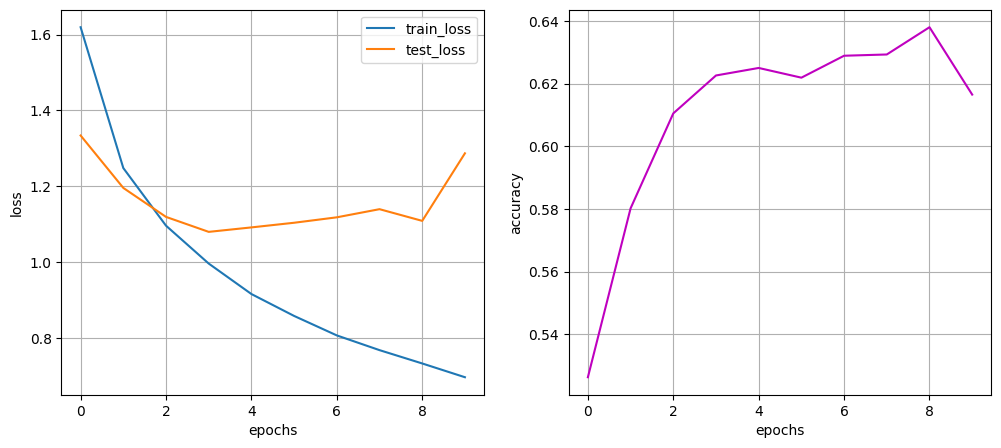

In [181]:
figure, ax = plt.subplots(1, 2, figsize=(12,5))
plt.grid()

ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].plot(result[0], label="train_loss")
ax[0].plot(result[1], label="test_loss")
ax[0].legend()

ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].plot(result[2], color='m')
ax[0].grid()